In [1]:
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        }
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1},
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },

        
}

pipe = RubixPipeline(config)

data= pipe.run()

2024-05-14 20:05:20.492692: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-05-14 20:05:22,194 - rubix - INFO - Getting rubix data...
2024-05-14 20:05:22,196 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2024-05-14 20:05:23,812 - rubix - INFO - Data loaded with 484076 particles.
2024-05-14 20:05:23,814 - rubix - INFO - Setting up the pipeline...
2024-05-14 20:05:23,815 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {'type': 'face-on'}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': 

rotating galaxy:  face-on


2024-05-14 20:05:24,532 - rubix - INFO - Pipeline run completed in 0.72 seconds.


In [2]:
print(data.keys())

dict_keys(['age', 'coords', 'mass', 'metallicity', 'n_particles', 'pixel_assignment', 'spatial_bin_edges', 'velocities'])


In [3]:
mass = data["mass"]
metallicity = data["metallicity"]
age = data["age"]

'''
n_stars = -1
#get the first n_stars

mass = mass[:n_stars]
metallicity = metallicity[:n_stars]
age = age[:n_stars]
'''


'\nn_stars = -1\n#get the first n_stars\n\nmass = mass[:n_stars]\nmetallicity = metallicity[:n_stars]\nage = age[:n_stars]\n'

In [4]:
import jax 
n_gpus = jax.device_count()
print(n_gpus)

4


In [5]:
mass = mass.reshape(n_gpus, -1)
metallicity = metallicity.reshape(n_gpus, -1)
age = age.reshape(n_gpus, -1)
assignments = data["pixel_assignment"].reshape(n_gpus, -1)



print(mass.shape)

(4, 121019)


In [6]:
# Calculate Spectrum for each GPU
from rubix.core.ssp import get_lookup 

lookup = get_lookup(config)
lookup

2024-05-14 20:05:24,690 - rubix - DEBUG - Method not defined, using default method: cubic


Partial(<PjitFunction of <function interp2d at 0x7052e1fb1120>>, method='cubic', x=Array([1.e-04, 4.e-04, 4.e-03, 8.e-03, 2.e-02, 5.e-02], dtype=float32), y=Array([ 0.       ,  5.100002 ,  5.1500006,  5.1999993,  5.25     ,
        5.3000016,  5.350002 ,  5.4000006,  5.4500012,  5.500002 ,
        5.550002 ,  5.600002 ,  5.6500025,  5.700002 ,  5.750002 ,
        5.8000026,  5.850003 ,  5.900003 ,  5.950003 ,  6.       ,
        6.0200005,  6.040001 ,  6.0599985,  6.0799985,  6.100002 ,
        6.120001 ,  6.1399984,  6.16     ,  6.18     ,  6.1999993,
        6.2200007,  6.24     ,  6.2599998,  6.2799997,  6.2999997,
        6.3199987,  6.3399997,  6.3600006,  6.3799996,  6.3999987,
        6.4200006,  6.44     ,  6.4599996,  6.4799995,  6.499999 ,
        6.52     ,  6.539999 ,  6.56     ,  6.5799994,  6.6      ,
        6.6199994,  6.6399994,  6.66     ,  6.679999 ,  6.699999 ,
        6.72     ,  6.7399993,  6.7599993,  6.7799997,  6.799999 ,
        6.819999 ,  6.839999 ,  6.85999

In [7]:
lookup(metallicity[0,0], age[0,0])

Array([-1.27299515e-09, -1.51717161e-09, -1.72796566e-09, -1.93353000e-09,
       -2.02662620e-09, -1.97615635e-09, -1.75276216e-09, -1.58773927e-09,
       -1.30480549e-09, -1.60878921e-09, -7.20021709e-10,  4.65535666e-10,
        1.24242181e-08,  1.64872329e-08,  1.76348856e-08,  1.89214795e-08,
        2.06260182e-08,  2.59375348e-08,  2.69612723e-08,  3.60669716e-08,
        3.84702687e-08,  1.31062350e-07,  3.38900406e-07,  3.53533125e-07,
        3.72926195e-07,  3.97917489e-07,  4.12978324e-07,  4.40905069e-07,
        4.58581070e-07,  4.76751268e-07,  4.94893015e-07,  5.07918287e-07,
        5.16820819e-07,  5.34890660e-07,  5.57735348e-07,  5.75772049e-07,
        5.90223124e-07,  6.09967685e-07,  6.23628125e-07,  6.13496468e-07,
        6.66712140e-07,  6.87347324e-07,  6.90289539e-07,  7.11947223e-07,
        1.09998894e-06,  1.80882614e-06,  2.37829477e-06,  2.15394516e-06,
        2.30908017e-06,  1.82942722e-06,  2.20399511e-06,  2.33034120e-06,
        2.29932948e-06,  

In [8]:
age.shape

(4, 121019)

In [9]:
from jax import vmap, pmap 

# Pmap over the GPUs, vmap over the particles


lookup_vmap = vmap(lookup, in_axes=(0, 0))

In [10]:
metallicity[0].shape

(121019,)

In [11]:
metallicity[0].shape

(121019,)

In [12]:
lookup_vmap(metallicity[0], age[0])

Array([[-1.2727341e-09, -1.5168979e-09, -1.7274399e-09, ...,
         3.7306543e-06,  3.6678998e-06,  3.6346380e-06],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.9309385e-09, -2.3252471e-09, -2.6688376e-09, ...,
         4.4983603e-06,  4.4230369e-06,  4.3830851e-06],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [13]:
#pmap across the GPUs
lookup_pmap = pmap(lookup_vmap, in_axes=(0, 0))

spectra = lookup_pmap(metallicity, age)
spectra.shape

(4, 121019, 842)

# Sum up the spectra inside the telescope pixels to calculate IFU cube

In [15]:
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 842))
    
    return ifu_cube

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

(25, 25, 842)

In [16]:
ssp = pipe.ssp
wavelengths = ssp.wavelength



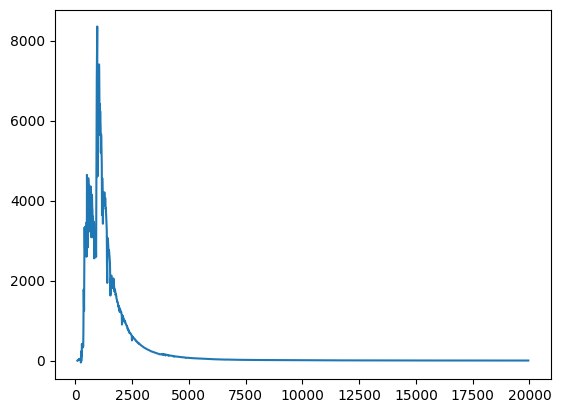

In [17]:
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths, spec)

In [18]:
final_ifu_cube.shape

(25, 25, 842)

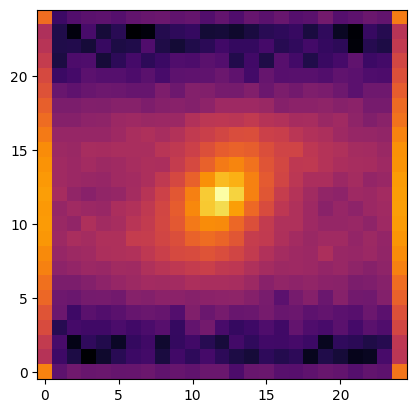

In [20]:
# Sum up all spectra to create an image
image = jnp.sum(final_ifu_cube, axis = 2)
image = jnp.log10(image + 1)
plt.imshow(image, origin="lower", cmap="inferno")